In [1]:
import pandas as pd
from os.path import join
from sklearn.utils import shuffle

emotions = ["happy", "sad", ["disgust", "disgust2"], "angry", "fear", "surprise"]
dir_path = "gathering/ja_tweets_sentiment"
size = 60000
df = []
for i, es in enumerate(emotions):
    if isinstance(es, list):
        for e in es:
            data = shuffle(pd.read_json(join(dir_path, "{}.json".format(e)))).iloc[:int(size/len(es))]
            data['label'] = i
            df.append(data)
    else:
        data = shuffle(pd.read_json(join(dir_path, "{}.json".format(es)))).iloc[:int(size)]
        data['label'] = i
        df.append(data)

df = pd.concat(df)
df.shape

(360000, 11)

In [2]:
df = shuffle(df)

In [3]:
X = df['text']
y = df['label']

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

max_features=10000
maxlen = 280

y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

tokenizer = Tokenizer(num_words=max_features, filters="", char_level=True)
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((202500, 280), (67500, 280), (90000, 280))

In [7]:
import pickle

with open("tokenizer_cnn_ja.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [8]:
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential

In [9]:
model = Sequential()
model.add(Embedding(max_features, 150, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
epochs = 15
batch_size = 1000

In [11]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

Train on 202500 samples, validate on 67500 samples
Epoch 1/15
202500/202500 [==============================] - 15s 75us/step - loss: 1.6038 - acc: 0.3209 - val_loss: 1.5504 - val_acc: 0.3619
Epoch 2/15
202500/202500 [==============================] - 8s 38us/step - loss: 1.4825 - acc: 0.4033 - val_loss: 1.4568 - val_acc: 0.4205
Epoch 3/15
202500/202500 [==============================] - 8s 38us/step - loss: 1.4100 - acc: 0.4498 - val_loss: 1.3896 - val_acc: 0.4602
Epoch 4/15
202500/202500 [==============================] - 8s 38us/step - loss: 1.3583 - acc: 0.4783 - val_loss: 1.3613 - val_acc: 0.4733
Epoch 5/15
202500/202500 [==============================] - 8s 38us/step - loss: 1.3260 - acc: 0.4936 - val_loss: 1.3385 - val_acc: 0.4853
Epoch 6/15
202500/202500 [==============================] - 8s 38us/step - loss: 1.3006 - acc: 0.5060 - val_loss: 1.3523 - val_acc: 0.4816
Epoch 7/15
202500/202500 [==============================] - 8s 38us/step - loss: 1.2798 - acc: 0.5162 - val_loss: 

In [12]:
import numpy as np
y_preds = model.predict(X_test)
y_preds = np.argmax(y_preds, axis=1)
y_true = np.argmax(y_test, axis=1)

In [13]:
emolabels = []
for e in emotions:
    if isinstance(e, list):
        emolabels.append(e[0])
    else:
        emolabels.append(e)

In [14]:
from sklearn.metrics import classification_report

In [15]:
print(classification_report(y_true, y_preds, target_names=emolabels))

             precision    recall  f1-score   support

      happy       0.50      0.64      0.56     15040
        sad       0.61      0.51      0.55     14918
    disgust       0.39      0.52      0.45     15205
      angry       0.56      0.42      0.48     15050
       fear       0.49      0.52      0.50     14888
   surprise       0.51      0.38      0.44     14899

avg / total       0.51      0.50      0.50     90000



In [16]:
model.save("models/ja_tweets_sentiment/model_2018-08-28-15:00.h5")

In [18]:
from keras.models import load_model
import pickle
model = load_model("models/ja_tweets_sentiment/model_2018-08-28-15:00.h5")

with open("models/ja_tweets_sentiment/tokenizer_cnn_ja.pkl", "rb") as f:
    tokenizer = pickle.load(f)

In [19]:
def preprocess(data, tokenizer, maxlen=280):
    return(pad_sequences(tokenizer.texts_to_sequences(data), maxlen=maxlen))

In [21]:
examples = [
    "まじきもい、あいつ",
    "今日は楽しい一日だったよ",
    "ペットが死んだ、実に悲しい",
    "ふざけるな、死ね",
    "ストーカー怖い",
    "すごい！ほんとに！？",
    "葉は植物の構成要素です。",
    "ホームレスと囚人を集めて革命を起こしたい"
]

targets = preprocess(examples, tokenizer, maxlen=maxlen)
print('\t'.join(emolabels))
for i, ds in enumerate(model.predict(targets)):
    print('\t'.join([str(round(100.0*d)) for d in ds]))

happy	sad	disgust	angry	fear	surprise
3.0	4.0	12.0	9.0	6.0	3.0
16.0	4.0	3.0	1.0	2.0	2.0
0.0	13.0	2.0	0.0	4.0	0.0
2.0	2.0	9.0	14.0	3.0	2.0
0.0	4.0	9.0	1.0	31.0	2.0
1.0	1.0	1.0	1.0	2.0	21.0
24.0	1.0	1.0	0.0	0.0	3.0
2.0	1.0	2.0	17.0	5.0	3.0


まじきもい、あいつ


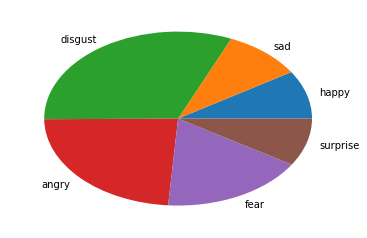

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pie(model.predict(targets)[0]*100.0, labels=emolabels)
print(examples[0])

今日は楽しい一日だったよ


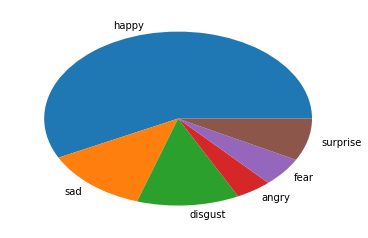

In [30]:
plt.pie(model.predict(targets)[1]*100.0, labels=emolabels)
print(examples[1])

ペットが死んだ、実に悲しい


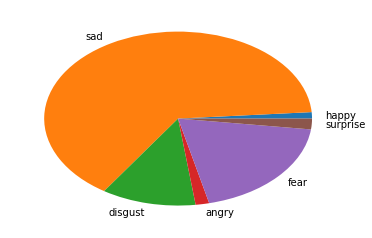

In [31]:
plt.pie(model.predict(targets)[2]*100.0, labels=emolabels)
print(examples[2])

ふざけるな、死ね


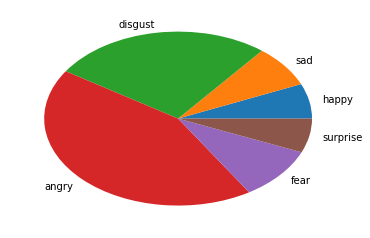

In [32]:
plt.pie(model.predict(targets)[3]*100.0, labels=emolabels)
print(examples[3])

ストーカー怖い


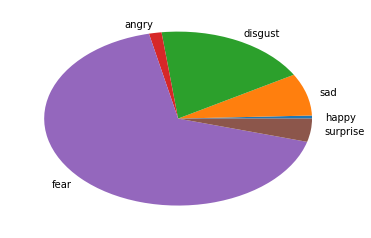

In [33]:
plt.pie(model.predict(targets)[4]*100.0, labels=emolabels)
print(examples[4])

すごい！ほんとに！？


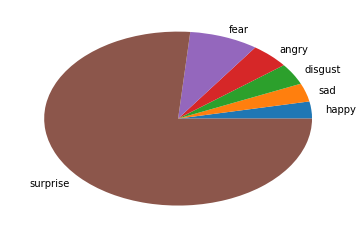

In [34]:
plt.pie(model.predict(targets)[5]*100.0, labels=emolabels)
print(examples[5])

ホームレスと囚人を集めて革命を起こしたい


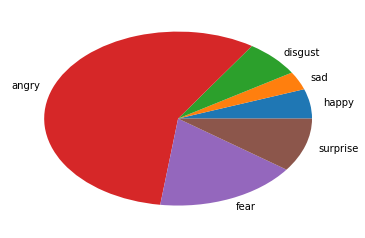

In [35]:
plt.pie(model.predict(targets)[7]*100.0, labels=emolabels)
print(examples[7])